# Análise e Transformação de Dados
## Milestone 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from glob import glob
from scipy.stats import zscore
import librosa
import librosa.display
import IPython.display as ipd
from itertools import cycle
from sklearn.preprocessing import MinMaxScaler
import pingouin as pg


sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])


# Load the Data

### 1. Desenvolva código para importação dos sinais de áudio. 

In [2]:
audio_files = sorted(glob('dataset/01/*.wav'))
audio_files

['dataset/01/0_01_0.wav',
 'dataset/01/0_01_1.wav',
 'dataset/01/0_01_10.wav',
 'dataset/01/0_01_11.wav',
 'dataset/01/0_01_12.wav',
 'dataset/01/0_01_13.wav',
 'dataset/01/0_01_14.wav',
 'dataset/01/0_01_15.wav',
 'dataset/01/0_01_16.wav',
 'dataset/01/0_01_17.wav',
 'dataset/01/0_01_18.wav',
 'dataset/01/0_01_19.wav',
 'dataset/01/0_01_2.wav',
 'dataset/01/0_01_20.wav',
 'dataset/01/0_01_21.wav',
 'dataset/01/0_01_22.wav',
 'dataset/01/0_01_23.wav',
 'dataset/01/0_01_24.wav',
 'dataset/01/0_01_25.wav',
 'dataset/01/0_01_26.wav',
 'dataset/01/0_01_27.wav',
 'dataset/01/0_01_28.wav',
 'dataset/01/0_01_29.wav',
 'dataset/01/0_01_3.wav',
 'dataset/01/0_01_30.wav',
 'dataset/01/0_01_31.wav',
 'dataset/01/0_01_32.wav',
 'dataset/01/0_01_33.wav',
 'dataset/01/0_01_34.wav',
 'dataset/01/0_01_35.wav',
 'dataset/01/0_01_36.wav',
 'dataset/01/0_01_37.wav',
 'dataset/01/0_01_38.wav',
 'dataset/01/0_01_39.wav',
 'dataset/01/0_01_4.wav',
 'dataset/01/0_01_40.wav',
 'dataset/01/0_01_41.wav',
 'data

#### Neste projeto decidimos usar a pasta 1.

In [3]:
#Reprodução do Audio
# Three
ipd.Audio(audio_files[62])

 ### 2. Reproduza e represente graficamente um exemplo dos sinais importados, identificando o dígito a que cada um corresponde, e indicando o eixo horizontal com o tempo em segundos, como apresentado no exemplo da Figura 2.

In [4]:
data = []
labels = []

sample_rate = 48000

# Get the length of the longest audio file
max_length = max(len(librosa.load(file_path)[0]) for file_path in audio_files)

for file_path in audio_files:
    y, sr = librosa.load(file_path)
    # Padding
    if len(y) < max_length:
        y = np.pad(y, (0, max_length - len(y)))
    data.append(y)
    
    # Split the file path to keep the '0'
    split_path = int(file_path.split('/')[2][0])
    labels.append(split_path)

# Convert to arrays
data_arr = np.array(data)
labels_arr = np.array(labels).astype(int)

In [5]:
#(File Number, Sample rate)
data_arr.shape

(500, 20191)

In [6]:
#(labels,)
labels_arr.shape

(500,)

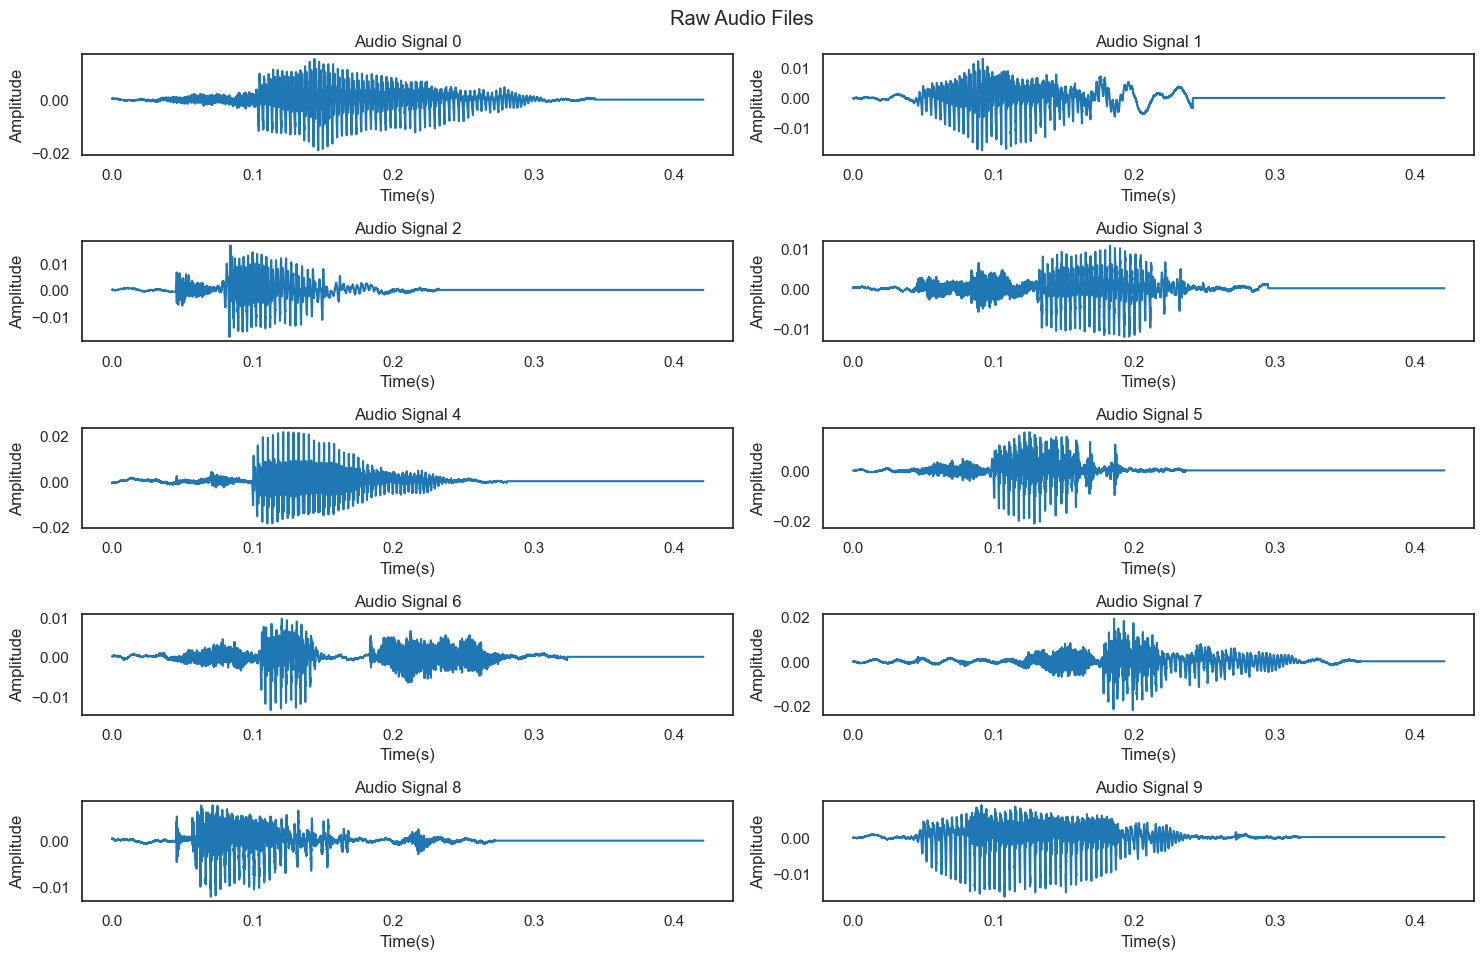

In [7]:
plt.figure(figsize=(15, 15))

# List of file indices
file_indices = [0, 52, 102, 152, 202, 252, 302, 352, 402, 460]

for i, file_index in enumerate(file_indices):
    # Create a time array
    time = np.arange(len(data_arr[file_index, :-1])) / sample_rate
    
    # Create a subplot for the i-th file
    plt.subplot(8, 2, i+1)
    plt.plot(time, data_arr[file_index, :-1])
    plt.title(f'Audio Signal {labels_arr[file_index]}')
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')

plt.suptitle('Raw Audio Files') 
plt.tight_layout()
plt.show()

#### Inicialmente começamos por discretizar o sinal. Decidimos guardar 2 listas separadas, uma com o dados, outra com as labels (predictions) correspondentes de cada ficheiro audio, caso eventualmente fosse necessário.

#### Identificamos o ficheiro mais longo e aplicamos o padding aos outros ficheiros para ficarem com o mesmo tamanho. de forma a obter o tempo no eixo do X, dividimios o tamanho do ficheiro pelo samplerate.
#### 48000hz = 48mil registos por segundo

# Preprocess the Data

In [8]:
trimmed_data_arr = []

# usei librosa top_db = 20 function to delete silence
for i in range(len(data_arr)):
    trimmed_signal, _ = librosa.effects.trim(data_arr[i], top_db=20)
    trimmed_data_arr.append(trimmed_signal)

In [9]:
#normalizing the audio and transforming the Zeros to avoid clipping
padding_value = 0

for i in range(len(trimmed_data_arr)):
    trimmed_data_arr[i] = trimmed_data_arr[i].astype(float)
    # Replace padding with NaN
    trimmed_data_arr[i][trimmed_data_arr[i] == padding_value] = np.nan
    trimmed_data_arr[i] = trimmed_data_arr[i] / np.nanmax(np.abs(trimmed_data_arr[i]))
    # Replace NaNs with the padding value
    trimmed_data_arr[i] = np.nan_to_num(trimmed_data_arr[i], nan=padding_value)

In [10]:
# for i in range(len(trimmed_data_arr)):
#     trimmed_data_arr[i] = ( trimmed_data_arr[i] - np.mean(trimmed_data_arr[i]) ) / (np.std(trimmed_data_arr[i]))

In [11]:
max_length = max(len(x) for x in trimmed_data_arr)  # Get the length of the longest audio signal

for i in range(len(trimmed_data_arr)):
    # Pad or truncate the i-th audio signal to max_length
    trimmed_data_arr[i] = np.pad(trimmed_data_arr[i], (0, max_length - len(trimmed_data_arr[i])), mode='constant', constant_values=0)

trimmed_data_arr = np.array(trimmed_data_arr)

In [12]:
trimmed_data_arr = trimmed_data_arr[:,:12000]

In [13]:
trimmed_data_arr.shape

(500, 12000)

In [14]:
# Identificar Outliers
z_score_threshold = 3

# Identificiar outliers individualmente por cada linha (ficheiro)
for i in range(trimmed_data_arr.shape[0]):
    # Select the row
    row = trimmed_data_arr[i, :]

    # Compute the Z-scores
    z_scores = zscore(row)

    # Substituir os Outliers identificados através de interpolação linear
    x = np.arange(len(row))
    outliers_mask = np.abs(z_scores) > z_score_threshold
    row[outliers_mask] = np.interp(x[outliers_mask], x[~outliers_mask], row[~outliers_mask])

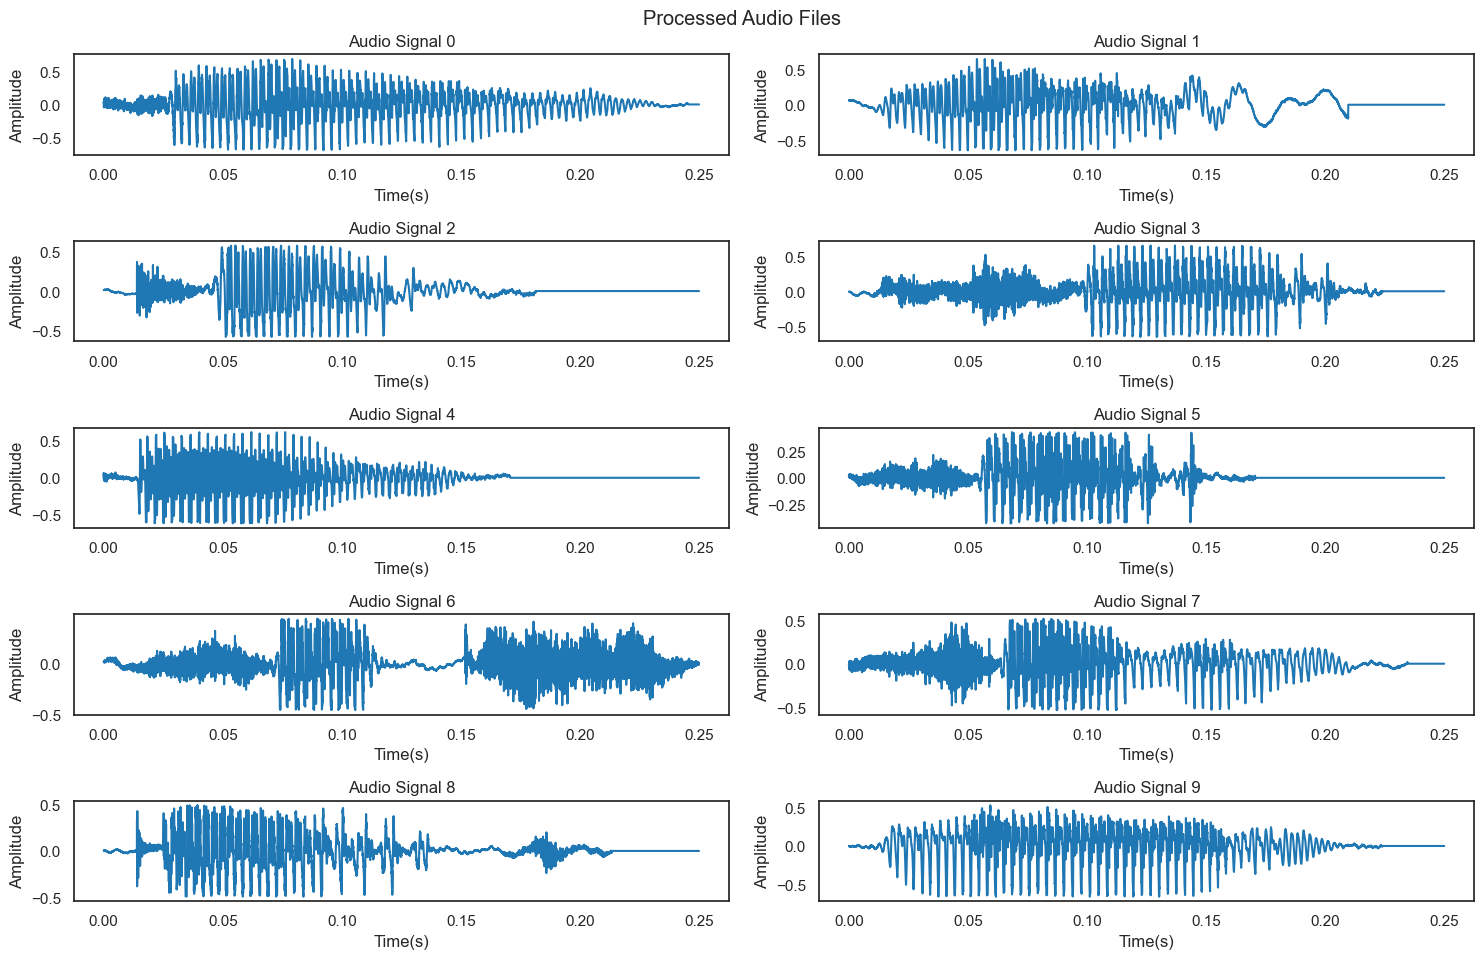

In [15]:
plt.figure(figsize=(15, 15))

# List of file indices
file_indices = [0, 52, 102, 152, 202, 252, 302, 362, 402, 460]

for i, file_index in enumerate(file_indices):
    # Create a time array
    time = np.arange(len(trimmed_data_arr[file_index, :-1])) / sample_rate
    
    plt.subplot(8, 2, i+1)
    plt.plot(time, trimmed_data_arr[file_index, :-1])
    plt.title(f'Audio Signal {labels_arr[file_index]}')
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    
plt.suptitle('Processed Audio Files') 
plt.tight_layout()
plt.show()

### Na fase de preprocesssamento, usamos a funcionalidade do Librosa para começar os audios a partir de 15db e assim remover o ruído inicial.
### Aplicou-se a normalização e respetiva deteção de outliers através da transformada Z (para Z > 3 interpolar os dados).

### fiz alguns "zooms" para confirmar se estamos na transiente que inicia a palavra e não estamos a perder dados.

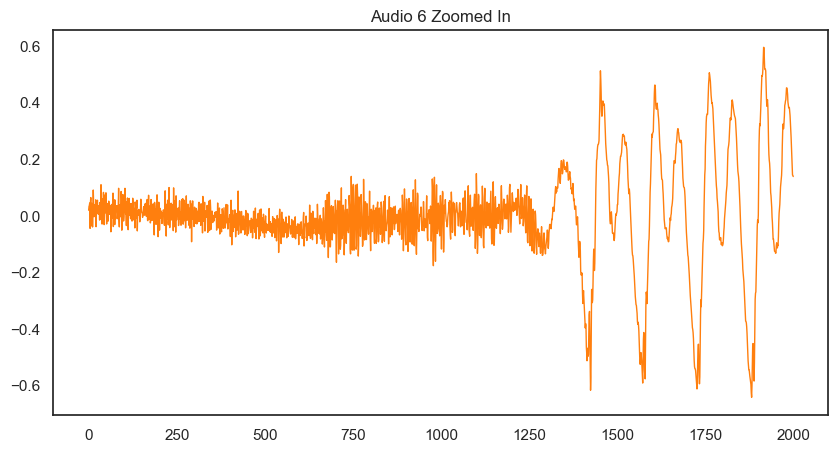

In [16]:
pd.Series(trimmed_data_arr[0, :2000]).plot(figsize=(10, 5),
                  lw=1,
                  title='Audio 6 Zoomed In',
                 color=color_pal[1])
plt.show()

In [17]:
ipd.Audio(trimmed_data_arr[302,:], rate = 24000)

# Parte 3 
### Definir as Features

#### dividi os ficheiros em 4 partes iguais para extrair features.

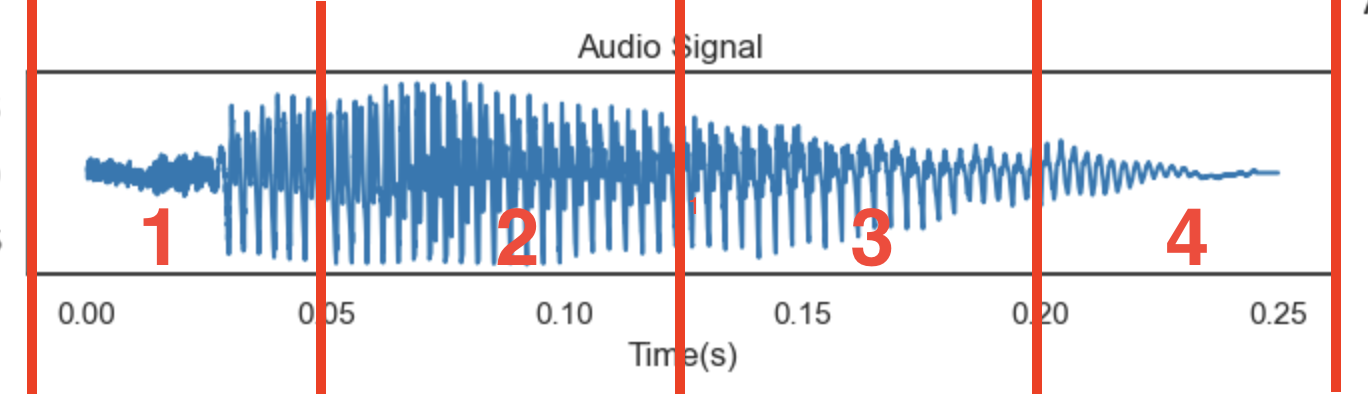

### Feature 1 - Desvio Padrão

$$\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}$$

### Calculei o desvio padrao no primeiro quadrante para tentar capturar algo que se aproximasse da amplitude "entender quanto se desvia da média". 


In [18]:
# Determine the number of files and the chunk size
num_files = trimmed_data_arr.shape[0]
chunk_size = 50

# Initialize an empty DataFrame to store the standard deviations
std_devs = pd.DataFrame()

# For each chunk of files
for i in range(0, num_files, chunk_size):
    # Calculate the standard deviations for the files in the chunk
    std_dev_chunk = np.std(trimmed_data_arr[i:i+chunk_size, :3000], axis=1)

    # Store the standard deviations in a new column of the DataFrame
    std_devs[i // chunk_size] = std_dev_chunk

In [19]:
std_devs

,0,1,2,3,4,5,6,7,8,9
0,0.248070,0.208414,0.165448,0.084428,0.111942,0.242383,0.057684,0.155596,0.271960,0.227327
1,0.145332,0.248837,0.134089,0.060012,0.053099,0.145269,0.058798,0.049748,0.248589,0.271078
2,0.220379,0.241950,0.194205,0.090257,0.302061,0.088591,0.068161,0.034942,0.213643,0.181122
3,0.228786,0.243084,0.187725,0.108702,0.037658,0.037047,0.069344,0.088856,0.208251,0.203143
4,0.107609,0.239537,0.101717,0.110456,0.259758,0.176465,0.054280,0.046313,0.257942,0.227509
5,0.117266,0.199840,0.168367,0.073053,0.068306,0.226535,0.097493,0.077689,0.256535,0.216617
6,0.080999,0.181002,0.200617,0.145707,0.134007,0.228831,0.071505,0.082651,0.216889,0.216650
7,0.063830,0.214072,0.152725,0.050467,0.250532,0.052135,0.063110,0.201217,0.293086,0.207545
8,0.180780,0.221853,0.174393,0.059119,0.174848,0.216483,0.068210,0.101835,0.201615,0.193451
9,0.228067,0.248462,0.168693,0.063381,0.287761,0.233960,0.078709,0.039521,0.220065,0.155634


# Feature 2 - Energia quadrante 2

$$E = \sum_{i=1}^{N} x_i^2$$

### com base em análises auxiliares infra, pude aferir através da informação mútua que o segundo e terceiro quadrante dos ficheiros seriam os que continham mais informação, logo foram essas 2 features que usei

In [20]:
# Determine the number of files and the chunk size
num_files = trimmed_data_arr.shape[0]
chunk_size = 50

# Initialize an empty DataFrame to store the standard deviations
energy1 = pd.DataFrame()

# For each chunk of files
for i in range(0, num_files, 50):
    # Calculate the standard deviations for the files in the chunk
    std_dev_chunk = np.sum(trimmed_data_arr[i:i+50, 3000:6000] ** 2, axis=1)

    # Store the standard deviations in a new column of the DataFrame
    energy1[i // 50] = std_dev_chunk


In [21]:
energy1

,0,1,2,3,4,5,6,7,8,9
0,303.781221,178.401078,325.980415,273.871302,223.848240,123.557702,119.263751,150.043394,145.203329,271.545121
1,281.592299,159.714925,226.562684,203.245887,175.893010,155.214800,69.636726,76.445299,26.292810,342.877180
2,186.864616,218.518616,268.472568,132.788245,145.017572,144.163399,129.924257,23.910635,117.696015,148.518681
3,168.781891,90.970828,256.794079,212.502238,70.606052,90.713128,129.123525,226.586171,255.601592,223.164961
4,312.696097,156.547432,242.695310,321.186418,51.971839,127.828823,69.083060,92.857428,98.971333,190.243901
5,264.804467,105.327006,266.396259,126.166714,164.503774,49.612169,112.165437,212.960128,154.131033,226.752073
6,304.481131,69.996026,276.502131,334.737799,300.521677,135.464513,143.428104,140.900222,169.715440,248.822914
7,130.759250,142.783266,363.784702,231.955583,74.668902,158.538847,110.302127,159.065930,163.190527,272.625966
8,244.663816,137.598637,345.625227,157.041226,228.193853,142.445309,76.281375,216.516446,50.418819,194.389984
9,323.628133,142.485845,174.957588,268.864047,98.859048,77.044432,70.939156,70.991046,64.084048,227.280941


# Feature 3 - Diferença de Energia entre quadrante 4 e 3

In [22]:
# Determine the number of files and the chunk size
num_files = trimmed_data_arr.shape[0]
chunk_size = 50

# Initialize an empty DataFrame to store the standard deviations
energy2 = pd.DataFrame()

# For each chunk of files
for i in range(0, num_files, 50):
    # Calculate the standard deviations for the files in the chunk
    std_dev_chunk = np.sqrt((np.sum(trimmed_data_arr[i:i+50, 6000:9000] ** 2, axis=1) - np.sum(trimmed_data_arr[i:i+50, 9000:12000]))**2)

    # Store the standard deviations in a new column of the DataFrame
    energy2[i // 50] = std_dev_chunk


In [23]:
energy2

,0,1,2,3,4,5,6,7,8,9
0,195.442230,53.734378,126.589031,99.354533,117.459373,48.601842,103.878907,153.782971,25.997309,268.698477
1,153.368521,60.231593,118.332419,133.128729,140.920129,42.392861,106.643971,220.763719,25.691189,451.367532
2,124.484700,15.532109,124.788398,259.211662,90.745364,42.029227,133.305763,250.098540,21.766045,197.833784
3,95.744095,81.819955,117.410644,146.624587,202.194047,140.071747,105.123220,173.844467,23.050630,295.587512
4,195.892310,50.361809,183.923760,88.726639,76.679924,41.369650,105.079551,223.715835,19.649055,197.375521
5,323.248864,76.262843,127.350534,313.885134,108.176703,29.548527,117.590334,182.326017,30.796466,221.992572
6,261.252653,74.650094,132.467739,18.561110,111.815936,28.868696,104.561254,140.795208,21.355974,312.698368
7,142.037176,58.499509,172.764220,122.126036,79.967180,103.652145,104.859068,168.634703,14.440435,278.947454
8,123.372851,73.751209,224.116709,123.042774,119.731815,58.692369,136.880914,151.292038,23.839347,264.770413
9,182.837403,80.901532,119.909277,77.550702,76.302185,28.836403,107.180074,242.649947,25.192648,340.817325


#### Como última feature, fiz a diferença da energia entre os 2 ultimos quadrantes. Para não dar valores negativos fiz a Raiz quadrada de (Q3 - Q4)**2

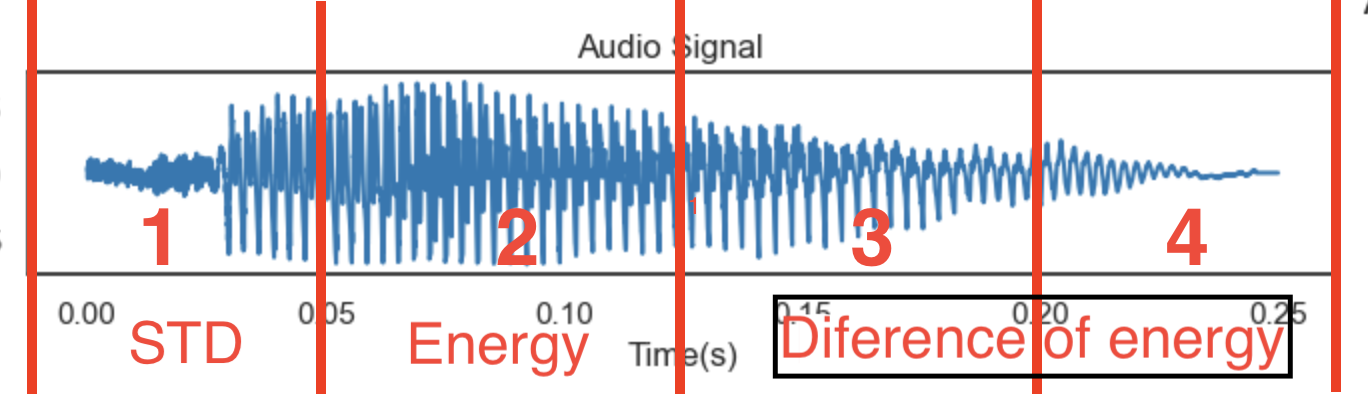

# Apresentar as Features

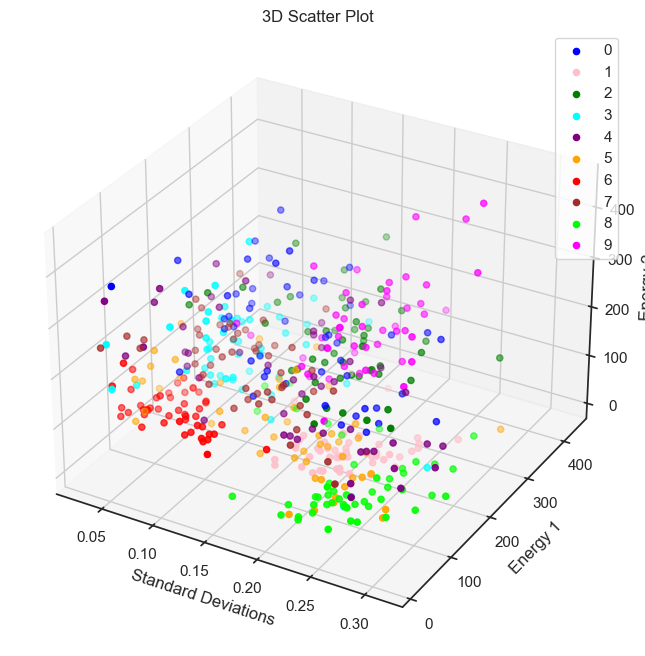

In [24]:
# Create a new figure
fig = plt.figure(figsize=(10, 8))

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

ax.scatter(std_devs[0], energy1[0], energy2[0], color='blue', label='0') 
ax.scatter(std_devs[1], energy1[1], energy2[1], color='pink', label='1')
ax.scatter(std_devs[2], energy1[2], energy2[2], color='green', label='2')
ax.scatter(std_devs[3], energy1[3], energy2[3], color='cyan', label='3') #
ax.scatter(std_devs[4], energy1[4], energy2[4], color='purple', label='4')
ax.scatter(std_devs[5], energy1[5], energy2[5], color='orange', label='5')
ax.scatter(std_devs[6], energy1[6], energy2[6], color='red', label='6')
ax.scatter(std_devs[7], energy1[7], energy2[7], color='brown', label='7')
ax.scatter(std_devs[8], energy1[8], energy2[8], color='lime', label='8')
ax.scatter(std_devs[9], energy1[9], energy2[9], color='magenta', label='9')


# Set the title and axis labels
ax.set_title('3D Scatter Plot')
ax.set_xlabel('Standard Deviations')
ax.set_ylabel('Energy 1')
ax.set_zlabel('Energy 2')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [35]:
import plotly.graph_objects as go
import numpy as np

# Flatten 3D arrays to 1D arrays
std_devs_flat = np.array(std_devs).flatten()
energy1_flat = np.array(energy1).flatten()
energy2_flat = np.array(energy2).flatten()

# Create a list of colors for each point
colors = ['blue', 'pink', 'green', 'cyan', 'purple', 'orange', 'red', 'brown', 'lime', 'magenta']
colors = colors * (len(std_devs_flat) // len(colors)) + colors[:len(std_devs_flat) % len(colors)]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=std_devs_flat, y=energy1_flat, z=energy2_flat,
                                   mode='markers',
                                   marker=dict(size=2, color=colors))])

# Set the title and axis labels
fig.update_layout(scene=dict(xaxis_title='Standard Deviations',
                             yaxis_title='Energy 1',
                             zaxis_title='Energy 2'),
                  title='3D Scatter Plot')

# Show the plot
fig.show()

### com apenas 3 features conseguimos uma separação bastante razoável entre as classes. Visualmente já conseguimos identificar alguns clusters

# Cálculos Auxiliares

# informação mútua

In [26]:
def energy(data):
    squared_sums = np.sum(data**2, axis=1)
    return np.mean(squared_sums)

numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
energies = []

energies_1_4 = []

energies_2_4 = []

energies_3_4 = []

energies_4_4 = []

#total
for i in range(0, 500, 50):
    subset = trimmed_data_arr[i:i+50, :]
    subset_energy = energy(subset)
    energies.append(subset_energy)

#first quarter
for i in range(0, 500, 50):
    subset1 = trimmed_data_arr[i:i+50, :2500]
    subset_energy1 = energy(subset1)
    energies_1_4.append(subset_energy1) 

#second quarter
for i in range(0, 500, 50):
    subset2 = trimmed_data_arr[i:i+50, 2500:5000]
    subset_energy2 = energy(subset2)
    energies_2_4.append(subset_energy2)  

# third quarter
for i in range(0, 500, 50):
    subset3 = trimmed_data_arr[i:i+50, 5000:7500]
    subset_energy3 = energy(subset3)
    energies_3_4.append(subset_energy3)    

# fourth quarter
for i in range(0, 500, 50):
    subset4 = trimmed_data_arr[i:i+50, 7500:10000]
    subset_energy4 = energy(subset3)
    energies_4_4.append(subset_energy4)  

# Create a DataFrame to store the energies
df = pd.DataFrame({'Numbers': numbers, 'Total Energy': energies, 'Energy 1/4': energies_1_4, 'Energy 2/4': energies_2_4, 'Energy 3/4': energies_3_4, 'Energy 4/4': energies_4_4})
df

,Numbers,Total Energy,Energy 1/4,Energy 2/4,Energy 3/4,Energy 4/4
0,0,427.591698,32.204227,209.298520,128.280599,148.91684
1,1,326.036093,97.186313,173.154966,49.369361,148.91684
2,2,407.623042,37.588737,266.844529,93.897698,148.91684
3,3,429.107046,21.287313,136.599531,207.014287,148.91684
4,4,346.057209,55.773642,169.849627,93.172703,148.91684
5,5,288.171399,62.692802,136.079268,70.867641,148.91684
6,6,124.899509,10.467132,80.688708,18.308559,148.91684
7,7,288.169938,25.211781,152.563827,66.670977,148.91684
8,8,309.910057,126.778617,151.370413,22.906016,148.91684
9,9,508.360128,93.523515,199.005275,148.916840,148.91684


In [27]:
# Create DataFrame
data = {
    'Total Energy': [469.676093, 389.950510, 468.391153, 490.513527, 424.736137, 
                     357.372587, 199.544427, 352.188861, 374.750431, 545.095555],
    'Energy 1/4': [145.449610, 150.399471, 109.878857, 90.491790, 216.850014, 
                    174.000781, 86.707351, 127.626045, 210.231807, 107.301371],
    'Energy 2/4': [217.637406, 193.976481, 296.389600, 242.337279, 162.822974, 
                    141.796437, 93.643747, 154.121309, 146.257271, 228.097406],
    'Energy 3/4': [81.970644, 41.923770, 58.264069, 142.959545, 40.446210, 
                    37.304695, 12.406734, 52.662864, 11.842641, 153.340382],
    'Energy 4/4': [153.340382, 153.340382, 153.340382, 153.340382, 153.340382, 
                    153.340382, 153.340382, 153.340382, 153.340382, 153.340382]
}

df = pd.DataFrame(data)

# Calculate entropy of each variable
entropies = df.apply(lambda x: -np.sum((x.value_counts(normalize=True) * np.log2(x.value_counts(normalize=True)))), axis=0)

# Sort variables based on entropy
sorted_vars = entropies.sort_values().index

# Define number of bins
num_bins = 3

# Perform binning
bins = {}
for var in sorted_vars:
    bins[var] = pd.cut(df[var], bins=num_bins, labels=[f'bin_{i+1}' for i in range(num_bins)])

# Display binned data
binned_df = pd.DataFrame(bins)
print(binned_df)

  Energy 4/4 Total Energy Energy 1/4 Energy 2/4 Energy 3/4
0      bin_2        bin_3      bin_2      bin_2      bin_2
1      bin_2        bin_2      bin_2      bin_2      bin_1
2      bin_2        bin_3      bin_1      bin_3      bin_1
3      bin_2        bin_3      bin_1      bin_3      bin_3
4      bin_2        bin_2      bin_3      bin_2      bin_1
5      bin_2        bin_2      bin_3      bin_1      bin_1
6      bin_2        bin_1      bin_1      bin_1      bin_1
7      bin_2        bin_2      bin_1      bin_1      bin_1
8      bin_2        bin_2      bin_3      bin_1      bin_1
9      bin_2        bin_3      bin_1      bin_2      bin_3


In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

# Your data
data = {
    'Total Energy': ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2'],
    'Energy 1/4': ['3', '2', '3', '3', '2', '2', '1', '2', '2', '3'],
    'Energy 2/4': ['2', '2', '1', '1', '3', '3', '1', '1', '3', '1'],
    'Energy 3/4': ['2', '1', '3', '3', '2', '1', '1', '1', '1', '2'],
    'Energy 4/4': ['2', '1', '1', '3', '1', '1', '1', '1', '1', '3'],
    'Predictor': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
}

df = pd.DataFrame(data)

# Convert categorical variables to numerical labels
le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)

# Extract the target variable
target = df_encoded['Predictor']

# Extract features (excluding the target variable)
features = df_encoded.drop('Predictor', axis=1)

# Calculate mutual information for classification
mi_scores = mutual_info_classif(features, target, discrete_features=True)

# Display the mutual information scores for each feature
for feature, score in zip(features.columns, mi_scores):
    print(f"Mutual Information for {feature}: {score}")


Mutual Information for Total Energy: 0.0
Mutual Information for Energy 1/4: 0.9433483923290394
Mutual Information for Energy 2/4: 1.0296530140645737
Mutual Information for Energy 3/4: 1.0296530140645737
Mutual Information for Energy 4/4: 0.8018185525433373


### Escolher as features energia 2/4 e 3/4, pois são as quem tem maior ganho de informação.

#Spectogram

In [29]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 40)

In [30]:
m = librosa.db_to_power(y)
m

array([0.9999807 , 0.9999746 , 0.99998164, ..., 1.        , 1.        ,
       1.        ], dtype=float32)

# Spectogram

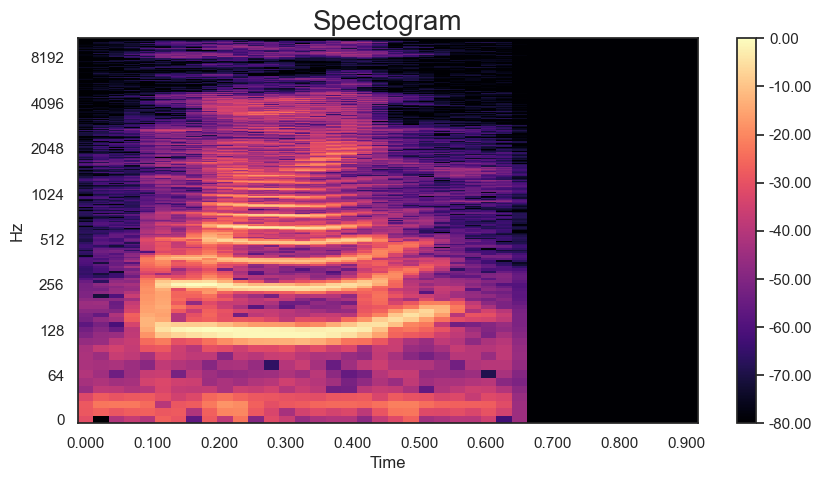

In [31]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# MEL SPECTOGRAM

In [32]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

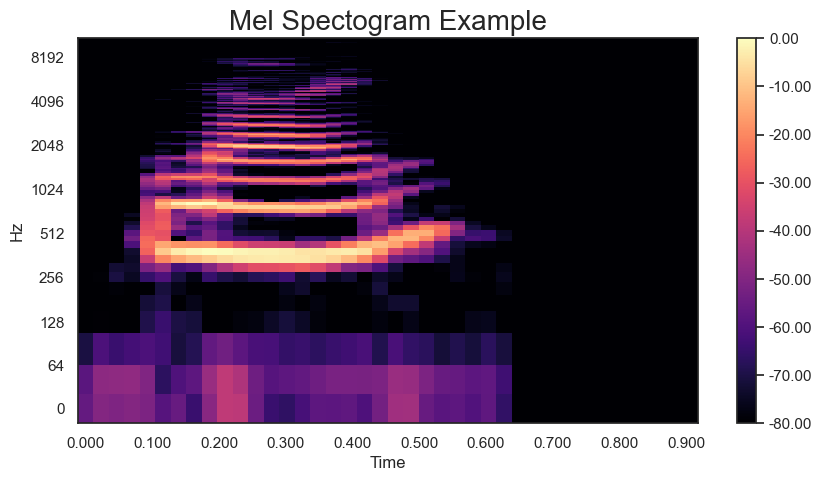

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

https://www.kaggle.com/code/robikscube/working-with-audio-in-python/notebook

#### Kar, A., & Das, L. (2011). A technical review on statistical feature extraction of ecg signal. In IJCA Special Issue on 2nd National Conference-Computing, Communication and Sensor Network, CCSN (pp. 35-40)